In [1]:
from pathlib import Path
import pickle as pkl
import random
import os

import torch
from torch.utils.data import DataLoader
import esm

from tqdm import tqdm
import pandas as pd
import numpy as np
import h5py

## Protein Embeddings Manipulation

In [2]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

class EmbeddingProtein1D:
    """
    Embedding Extractor for 1D protein sequences.
    """
    def __init__(self, model_name, open_func, data_path, gpu = False):
        """
        Constructor.
        
        Arguments:
        ---------
            model_name : str
                Can be one of the ESM models
                
            open_func : callable
                A callable function that loads the data into a train/test/val dictionary
                
            data_path: str or pathlib.Path
                The data's base path
                
            gpu : bool
                Whether to move the model to cuda.
                
        """
        
        self.model, self.alphabet = torch.hub.load("facebookresearch/esm", model_name)
        self.batch_converter = self.alphabet.get_batch_converter()
        self.open_func = open_func
        self.data_path = data_path
        self.data = None
        self.gpu = gpu
        self.kind = None
        if self.gpu:
            self.model.cuda()
            
    def open_embeddings(self, prefix, kind):
        """
        Opens a binary pkl file with the precomputed embeddings.
        """
        fname = (
            self.data_path
            / f'{prefix}_embeddings_{kind}.pkl'
        )
        return pkl.load(open(fname, 'rb'))
    
    
    def predict(self, sequence):
        """
        Obtains model's predictionsfor the given sequence.
        
        Arguments:
        ---------
            sequence: str
                An aminoacid sequence
                
        Returns:
        -------
            predictions : dict
        """
        # only one sequence
        if np.array(sequence).shape == ():
            sequence = sequence.upper()
            data = [("0", sequence)]
        else:
            data = sequence

        batch_labels, batch_strs, batch_tokens = self.batch_converter(data)
        with torch.no_grad():
            if self.gpu:
                batch_tokens = batch_tokens.cuda()
            predictions = self.model(batch_tokens, repr_layers=[33])
        return predictions
        
        
    def get_embedding(self, sequence, sequence_emb = True):
        """
        Obtains the embeddings model predictions and averages over 
        the sequence length to  obtain embedding representations.
        
        Arguments:
        ---------
            sequence: str
                An aminoacid sequence
            sequence_emb: bool
                Whether to reduce the token embeddings to obtain a sequence embedding
                
        Returns:
        --------
            sequence_embeddings/token_embeddings: str/list
        """
        results = self.predict(sequence)
    
        token_embeddings = results["representations"][33] # shape: (bs, seq_len, emb_dim)
        # NOTE: token 0 is always a beginning-of-sequence token, so the first residue is token 1.

        if sequence_emb: # one emb for the whole seq => average over seq_len
            if token_embeddings.shape[0] == 1:
                sequence_embeddings = (
                    token_embeddings[0, 1 : len(sequence) + 1].mean(dim=0).cpu().numpy()
                )
            else:
                sequence_embeddings = (
                    token_embeddings[:, 1 : len(sequence) + 1, :].mean(dim=1).cpu().numpy()
                )
            return sequence_embeddings
    
        return token_embeddings


    def generate_embeddings(self, file_prefix, save = False, kind = 'train', bs = 32, subset = None):
        """
        Generates sequence/token embeddings for a whole dataset.
        Can write the embeddings into a pickle file with the path_out argument.
        
        Arguments:
        ---------
            file_prefix : str, pathlib.Path
                A file prefix to load certain files from the data_path
                
            path_out : bool
                Whether to save the embeddings to a pickle file
                
            kind: str
                One of train/test/val sets
            
            bs: int
                The dataloader batch size
                
            subset: int
                A subset size of the train/test/val set
            
        """
        self.data = self.data if self.data is not None and self.kind == kind \
                              else self.open_func(self.data_path, file_prefix)[kind]
        self.kind = kind
    
        if subset is not None:
            random.choice(df.index)
            raise NotImplementedError

        # batch the dataset and return a batch of the form [(label, seq), ...]
        dl = DataLoader(
            list(self.data.itertuples(index=False, name=None)), 
            batch_size=bs, 
            collate_fn=lambda batch: batch
        )

        embeddings = {}
        for batch in tqdm(dl):
            batch_embeddings = self.get_embedding(batch)
            i = 0
            if len(batch_embeddings.shape) == 2:            
                for (label, seq), emb in zip(batch, batch_embeddings):
                    i +=1  
#                     print(i)
                    embeddings[seq] = emb
            else:
                label, seq = zip(*batch)
                embeddings[seq[0]] = batch_embeddings

        if save:
            out_fname = (
                self.data_path
                / f"{file_prefix}_embeddings_{kind}.pkl"
            )
            pkl.dump(embeddings, open(out_fname, 'wb'))
            print(f'Embeddings saved to {out_fname}')

        return embeddings
    
    
    def generate_datasets(self, file_prefix, save_emb = False, kind = 'train', bs = 32, subset = None, load_embeddings = False):
        """
        Generates sequence/token embeddings for a whole dataset.
        Can write the embeddings into a pickle file with the path_out argument.
        
        Arguments:
        ---------
            file_prefix : str, pathlib.Path
                A file prefix to load certain files from the data_path
                
            save_emb : bool
                Save precomputed embeddings
                
            kind: str
                One of train/test/val sets
            
            bs: int
                The dataloader batch size
                
            subset: int
                A subset size of the train/test/val set
                
            load_embeddings : bool
                Whether to load the embeddings from a file in the data_path.
                It assumes that file a is binary pickle and the file name is f"{file_prefix}_embeddings.pkl"
        """
        if subset:
            raise NotImplementedError(f"Subsets are not implemented yet")
            
        self.data = self.data if self.data is not None and self.kind == kind \
                              else self.open_func(self.data_path, file_prefix)[kind]
        self.kind = kind
        
        h5_fname = (
            self.data_path 
            / f"{file_prefix}_{kind}.h5"
        )
#         if Path(h5_fname).exists():
#             raise ValueError(f"Dataset {h5_fname} exists.")
            
        n_samples = len(self.data)
                
        embeddings = self.generate_embeddings(file_prefix, save=save_emb, kind=kind, bs=bs, subset=subset) \
                    if load_embeddings == False else self.open_embeddings(file_prefix, kind)
        
        emb_len = max([len(val) for val in embeddings.values()])
        
        with h5py.File(str(h5_fname), "w") as file_handler:
            dset_labels = file_handler.create_dataset(
                "labels", (n_samples,), dtype=self.data.labels.dtype
            )
            dset_embeddings = file_handler.create_dataset(
                "embeddings", (n_samples, emb_len)
            )
            dset_seqs = file_handler.create_dataset(
                "sequences", (n_samples,), dtype= h5py.string_dtype(encoding='utf-8', length=None)
            )
            
            dset_labels.attrs["target"] = file_prefix
            dset_labels[:] = self.data.labels
            dset_embeddings[:] = list(embeddings.values())
            dset_seqs[:] = self.data.sequence.astype(str)
            
            
        return h5py.File(str(h5_fname), "r")

### Utility Functions

In [3]:
def open_func(base_path, prefix):
    sets = {}

    for path in base_path.glob(f'{prefix}_*.csv'):
        fname = path.stem
        parts = fname.split('_')
        
        if len(parts) > 2:
            continue
        
        kind = parts[1]

        df = pd.read_csv(path)
        cols = df.columns
        df = df[cols[::-1]]
        df.columns = ['labels', 'sequence']
        [df.labels]
        
        sets[kind] = df
        
    return sets

In [4]:
data_path = Path('data')
open_func(data_path, 'stability')['train']

,labels,sequence
0,0.37,GSSQETIEVEDEEEARRVAKELRKKGYEVKDERRGNKWHVHRT
1,0.62,TLDEARELVERAKKEGTGMDVNGQRFEDWREAERWVREQEKNK
2,-0.03,TELKKKLEEALKKGEEVRVKFNGIEIRNTSEDAARKAVELLEK
3,1.41,GSSQETIEVEDEEEARRVAKELRKTGYEVKIERRGNKWHVHRT
4,1.11,TTIHVGDLTLKYDNPKKAYEIAKKLAKKYNLQVTIKNGKITVT
...,...,...
7705,0.80,GSSKTQYEYDTKEEHQKAYEKFKKQGIPVTITQKNGKWFVQVE
7706,0.82,TIDEIIKALEQAVKDNKPIQVGNYTVTSADEAEKLAKKLKKPY
7707,0.66,TQDEIIKALEQAVKDNKPIQVGNYTVTSADEAEKLAKKLKKEY
7708,1.05,TTIKVNGQEYTVPLSPEQAAKAAKKRWPDYEVQIHGNTVWVTR


In [5]:
args = AttrDict

args_dict = {
    'model_name': 'esm1b_t33_650M_UR50S',
    'open_func': open_func,
    'data_path': data_path,
    'gpu': True
}

emb_stabilty = EmbeddingProtein1D(**args_dict)

Using cache found in /home/step/.cache/torch/hub/facebookresearch_esm_master


In [6]:
# _ = emb_stabilty.generate_embeddings('stability', kind='test', save=True, bs=256)
# embeddings = emb_stabilty.generate_embeddings('stability', save=True, bs=256)

In [7]:
!rm data/stability_train.h5
h5_dset = emb_stabilty.generate_datasets('stability', load_embeddings=True)

In [8]:
h5_dset['embeddings'].shape

(7710, 1280)

## Dimensionality Reduction

(7710, 2)


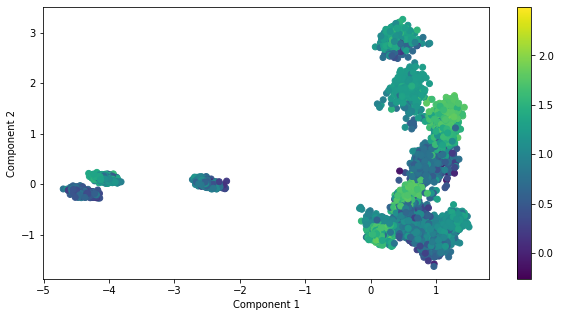

In [9]:
import matplotlib.pyplot as plt
import cuml

def dim_reduction(X, y, strategy = 'PCA', n_components = 2, prefix = None, plot_viz = True, save_viz = False):
    valid_strats = ("PCA", "UMAP", "TSNE")
    if strategy not in valid_strats:
        raise ValueError(f"{strategy} is not a valid dimensionality reduction strategy")
    
    if strategy == valid_strats[0]:
        reducer = cuml.PCA(n_components = n_components)
    elif strategy == valid_strats[1]:
        reducer = cuml.UMAP(n_components = 2)
    elif strategy == valid_strats[2]:
        reducer = cuml.PCA(n_components = 2)
        
    X_hat = reducer.fit_transform(X,y)
    print(X_hat.shape)
    if plot_viz:
        f, ax = plt.subplots(figsize=(10,5))
        scatter = ax.scatter(X_hat[:, 0], X_hat[:, 1], c=y)
        ax.set_xlabel('Component 1')
        ax.set_ylabel('Component 2')
        
        cb = plt.colorbar(scatter, spacing='proportional')
        cb.set_label(prefix)
        plt.show()
        
    return X_hat


X_train = h5_dset['embeddings'][:]
y_train = h5_dset['labels'][:].reshape(-1,1)
X_train_reduced = dim_reduction(X_train, y_train, plot_viz=True)



In [10]:
h5_dset['sequences'][:].shape, h5_dset['labels'][:].shape

((7710,), (7710,))

In [11]:
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.neural_network import MLPRegressor

scoring = "r2"
score = r2_score
models = {
    "SVR": {
        "model": SVR(),
        "params": {
            "C": [0.1, 1.0, 10.0],
            "kernel": ["linear", "poly", "rbf", "sigmoid"],
            "degree": [3],
            "gamma": ["scale"],
        },
    },
    "MLP": {
        "model": MLPRegressor(),
        "params": {
            "hidden_layer_sizes": [
                (100,),
                (
                    100,
                    100,
                ),
            ],
            "activation": ["tanh", "relu"],
            "solver": ["sgd", "adam"],
        },
    },
}

for name, model in models.items():
    print(f'Fitting model {name}...')
    grid = GridSearchCV(
        estimator=model["model"],
        cv=None,
        param_grid=model["params"],
        scoring=scoring,
        verbose=1,
        n_jobs=-1,
        refit=False,
    )
    grid.fit(X_train_reduced, y_train)
    print(name)
    print(grid.best_score_)
    print(grid.best_params_)

Fitting model SVR...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
SVR
0.443948909135652
{'C': 10.0, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'}
Fitting model MLP...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
MLP
0.6081704601184159
{'activation': 'relu', 'hidden_layer_sizes': (100, 100), 'solver': 'adam'}


/opt/miniconda3/envs/protera-rapids/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


(2571, 2)


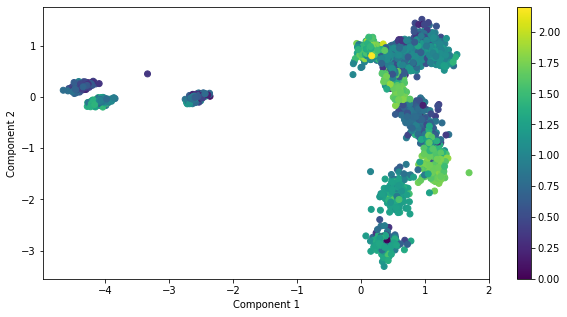

-0.8343186697370726

In [12]:
model = MLPRegressor(**{'activation': 'relu', 'hidden_layer_sizes': (100, 100), 'solver': 'adam'})
model.fit(X_train_reduced, y_train)



h5_dset = emb_stabilty.generate_datasets('stability', kind='test', load_embeddings=True)
X_test, y_test = h5_dset['embeddings'][:], h5_dset['labels'][:].reshape(-1,1)

X_test_red = dim_reduction(X_test, y_test)
model.score(X_test_red, y_test)

## Can a FeedForward Net do better?


In [13]:
from torch import nn
import torch.nn.functional as F

class ProteinMLP(nn.Module):
    
    def __init__(self, n_in = 1280, n_units = 1024, act = None, drop_p = 0.6):
        super(ProteinMLP, self).__init__()
        self.fc1 = nn.Linear(n_in, n_units)
        self.drop1 = nn.Dropout(p=drop_p)
        self.fc2 = nn.Linear(n_units, n_units//2)
        self.drop2 = nn.Dropout(p=drop_p)
        self.fc3 = nn.Linear(n_units//2, 1)
        self.drop3 = nn.Dropout(p=drop_p)
        
        
        self.act = act
        if act is None:
            self.act = nn.LeakyReLU()
            
    def forward(self, x):
        out = self.act(self.drop1(self.fc1(x)))
        out = self.act(self.drop2(self.fc2(out)))
        out = self.act(self.drop3(self.fc3(out)))
        
        return out

In [14]:
from skorch import NeuralNetRegressor

net = NeuralNetRegressor(
    ProteinMLP,
    max_epochs=30,
    lr=0.01,
    iterator_train__shuffle=True,
)

X_train = torch.from_numpy(X_train.astype('float32'))
y_train = torch.from_numpy(y_train.astype('float32'))
net.fit(X_train, y_train)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.8500        0.5666  0.7997
      2        0.8490        0.6682  0.7934
      3        0.8297        0.6443  0.7757
      4        0.8121        0.6050  0.7786
      5        0.8230        0.6332  0.5541
      6        0.8244        0.6531  0.7311
      7        0.8062        0.6362  0.7278
      8        0.8148        0.5531  0.7384
      9        0.8023        0.5581  0.6399
     10        0.8090        0.6960  0.5158
     11        0.8081        0.5734  0.5220
     12        0.8079        0.5993  0.5278
     13        0.8079        0.5886  0.5190
     14        0.8110        0.5418  0.5156
     15        0.8031        0.5245  0.5156
     16        0.7813        0.5223  0.5147
     17        0.8115        0.5189  0.5205
     18        0.8093        0.5382  0.5164
     19        0.7947        0.5204  0.5172
     20        0.7917        0.5996  0.5228
     21        0.7904        0.5

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=ProteinMLP(
    (fc1): Linear(in_features=1280, out_features=1024, bias=True)
    (drop1): Dropout(p=0.6, inplace=False)
    (fc2): Linear(in_features=1024, out_features=512, bias=True)
    (drop2): Dropout(p=0.6, inplace=False)
    (fc3): Linear(in_features=512, out_features=1, bias=True)
    (drop3): Dropout(p=0.6, inplace=False)
    (act): LeakyReLU(negative_slope=0.01)
  ),
)

In [15]:
net.score(X_test, y_test)

-2.0731044658189988